# Featuretools Solution for Predicting Survive of titanic sink

[kaggle](https://www.kaggle.com/c/titanic/overview)

참고한 노트북
* https://www.kaggle.com/startupsci/titanic-data-science-solutions



In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from featuretools.primitives import Count, Mean
import os
%matplotlib inline
import utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/train.csv', encoding='utf-8')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Baseline 형성
### 주어진 feature 목록만으로 RF 학습 

* score = 0.7821229050279329

In [49]:
# feature와 label로 분리
feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
string_columns = ['Sex', 'Cabin', 'Embarked']
y = data[["Survived"]]
X = data[feature_columns]

# categorical to numeric
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
for col_name in string_columns:
    X[col_name] = lbl.fit_transform(X[col_name].astype(str))

# Split into training and evaluation data:
from sklearn.model_selection import train_test_split as tts
X_train, X_val, y_train, y_val = tts(X, y, test_size= 0.2, random_state=42, shuffle=True, stratify=y)

# xgboost training
from xgboost import XGBClassifier
xgb = XGBClassifier(
    learning_rate = 0.005,
    n_estimators= 100,
    max_depth= 20,
    #min_child_weight= 2,
    #gamma=0.9,                        
    #subsample=0.8,
    #colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1
)

xgb.fit(X_train, y_train)
xgb.score(X_val, y_val)

0.776536312849162

# feature tools 사용

### entity set 형성

In [59]:
# 불필요한 column 제거
fm_raw = data.drop(columns=['Survived', 'Name', 'Ticket'])

# 데이터 유형 정의 
import featuretools.variable_types as vtypes
variable_types = {'Pclass': vtypes.Categorical,
                  'Sex': vtypes.Categorical,
                  'Age': vtypes.Categorical, # 의도적
                  'SibSp': vtypes.Categorical,
                  'Parch': vtypes.Categorical,
                  'Fare': vtypes.Numeric,
                  'Cabin': vtypes.Categorical,
                  'Embarked': vtypes.Categorical}

# entity 생성 및 관계 형성
es = ft.EntitySet('titanic-sink')
es = es.entity_from_dataframe(
    entity_id="persons",
    dataframe=fm_raw,
    index='PassengerId',
    #time_index=...,
    variable_types=variable_types)

es.normalize_entity(
    base_entity_id="persons",
    new_entity_id="boards",
    index="Embarked",
    make_time_index=False)

es.normalize_entity(
    base_entity_id="persons",
    new_entity_id="prices",
    index="Fare",
    make_time_index=False)

es.normalize_entity(
    base_entity_id="persons",
    new_entity_id="genders",
    index="Sex",
    make_time_index=False)

es.normalize_entity(
    base_entity_id="persons",
    new_entity_id="Ages",
    index="Age",
    make_time_index=False)

Entityset: titanic-sink
  Entities:
    persons [Rows: 891, Columns: 9]
    boards [Rows: 4, Columns: 1]
    prices [Rows: 248, Columns: 1]
    genders [Rows: 2, Columns: 1]
    Ages [Rows: 89, Columns: 1]
  Relationships:
    persons.Embarked -> boards.Embarked
    persons.Fare -> prices.Fare
    persons.Sex -> genders.Sex
    persons.Age -> Ages.Age

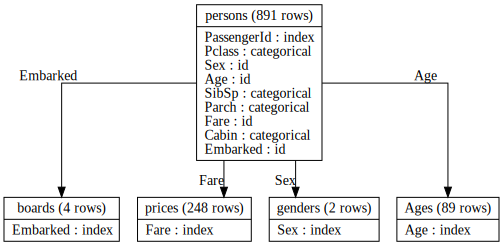

In [60]:
es.plot()

### Generating Features with Deep Feature Synthesis

In [61]:
# Generate features using the constructed entityset
fm, features = ft.dfs(entityset=es,
                      target_entity='persons',
                      agg_primitives=['skew', 'sum','std', 'max', 'mean', 'mode', 'count', 'num_unique', 'percent_true', 'entropy'],
                      #trans_primitives=['skew', 'weekday', 'day', 'month', 'year'],
                      max_depth=3,
                      #approximate='6h',
                      #cutoff_time=cutoff_times[20000:],
                      verbose=True)

Built 96 features
Elapsed: 00:03 | Progress: 100%|██████████


In [62]:
features[-20:]   # records쪽은 label빼고는 쓸 만한 feature가 없어서 난감 ㅠㅠ 

[<Feature: Ages.MODE(persons.Fare)>,
 <Feature: Ages.MODE(persons.Parch)>,
 <Feature: Ages.MODE(persons.Sex)>,
 <Feature: Ages.MODE(persons.Embarked)>,
 <Feature: Ages.MODE(persons.Pclass)>,
 <Feature: Ages.COUNT(persons)>,
 <Feature: Ages.NUM_UNIQUE(persons.SibSp)>,
 <Feature: Ages.NUM_UNIQUE(persons.Cabin)>,
 <Feature: Ages.NUM_UNIQUE(persons.Fare)>,
 <Feature: Ages.NUM_UNIQUE(persons.Parch)>,
 <Feature: Ages.NUM_UNIQUE(persons.Sex)>,
 <Feature: Ages.NUM_UNIQUE(persons.Embarked)>,
 <Feature: Ages.NUM_UNIQUE(persons.Pclass)>,
 <Feature: Ages.ENTROPY(persons.SibSp)>,
 <Feature: Ages.ENTROPY(persons.Cabin)>,
 <Feature: Ages.ENTROPY(persons.Fare)>,
 <Feature: Ages.ENTROPY(persons.Parch)>,
 <Feature: Ages.ENTROPY(persons.Sex)>,
 <Feature: Ages.ENTROPY(persons.Embarked)>,
 <Feature: Ages.ENTROPY(persons.Pclass)>]

In [63]:
# one-hot encoding
fm_encoded, features_encoded = ft.encode_features(fm, features)

In [64]:
len(fm_encoded.columns)

244

## 늘어난 feature로 학습

In [65]:
# Split into training and evaluation data:
from sklearn.model_selection import train_test_split as tts
X_train_ft, X_val_ft, y_train_ft, y_val_ft = tts(fm_encoded, y, test_size= 0.2, random_state=42, shuffle=True, stratify=y)

# xgboost training
from xgboost import XGBClassifier
xgb_ft = XGBClassifier(
    learning_rate = 0.005,
    n_estimators= 100,
    max_depth= 20,
    #min_child_weight= 2,
    #gamma=0.9,                        
    #subsample=0.8,
    #colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1
)

xgb_ft.fit(X_train_ft, y_train_ft)
xgb_ft.score(X_val_ft, y_val_ft)

0.7597765363128491

# 주요 feature 도식화 

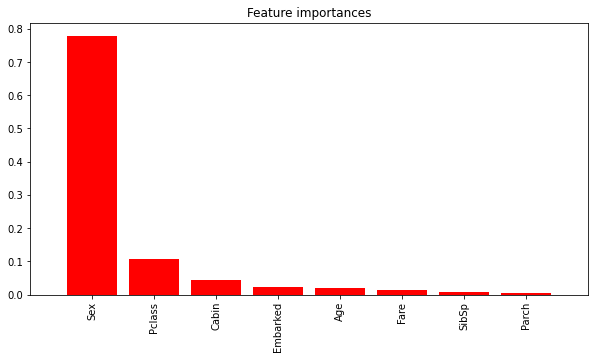

In [66]:
utils.show_feature_importance(X_train,xgb)

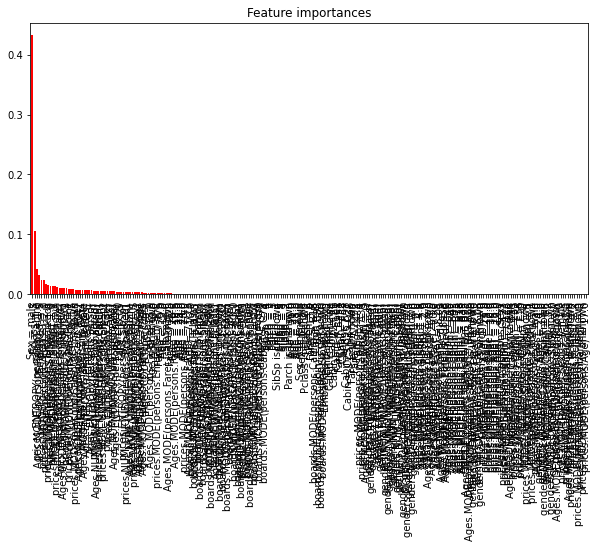

In [67]:
utils.show_feature_importance(X_train_ft,xgb_ft)